# Amazon Beauty Product Recommendation Engine

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import bz2
import io
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

from selenium import webdriver
from selenium.webdriver.common.by import By

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading dataset
az = pd.read_csv("ratings_Beauty.csv")
az["Rating"] = az["Rating"].astype(int)  #converting datatype to int
az.sort_values(by = ["ProductId"], ascending = False, inplace = True, ignore_index = True) #sorting values based on ProductId
az.head()

,UserId,ProductId,Rating,Timestamp
0,A1PB6OT0OOPKNQ,B00LU0LTOU,5,1405641600
1,AYBIB14QOI9PC,B00LPVG6V0,5,1405555200
2,AG9TJLJUN5OM3,B00LP2YB8E,5,1405382400
3,A3DEHKPFANB8VA,B00LOS7MEE,5,1405296000
4,A3DEHKPFANB8VA,B00LORWRJA,5,1405296000


In [3]:
# Total count of unique ProductId
az.ProductId.nunique()

249274

## EDA

In [4]:
# Function that returns value counts of specified column based on condition
def get_value_counts(data, column, value, operator = "="):
    counts = data[column].value_counts()
    if operator == "=":
        print(f"Value counts equal to {value}    : {len(counts[counts == value])}")
    elif operator == "<":
        print(f"Value counts less than {value}   : {len(counts[counts < value])}")
    elif operator == ">":
        print(f"Value counts greater than {value}: {len(counts[counts > value])}")
    else:
        print("Invalid operator, please use '=', '<' or '>'.")

In [5]:
# Counting for ProductId which are Infrequent
get_value_counts(az, "ProductId", 20, "<")
get_value_counts(az, "ProductId", 15, "<")
get_value_counts(az, "ProductId", 10, "<")
get_value_counts(az, "ProductId", 1)

Value counts less than 20   : 230179
Value counts less than 15   : 223885
Value counts less than 10   : 212336
Value counts equal to 1    : 103484


In [6]:
# Value count to find the max i.e popular products
az.ProductId.value_counts()

B001MA0QY2    7533
B0009V1YR8    2869
B0043OYFKU    2477
B0000YUXI0    2143
B003V265QW    2088
              ... 
B005KEH11C       1
B005KECH48       1
B005KDU5XO       1
B005KDRZCS       1
0205616461       1
Name: ProductId, Length: 249274, dtype: int64

In [7]:
# Creating a function that will drop rows based on value_count of specified column 
def drop_by_value_count(data, column, threshold, operator = "="):
    print("Original length of dataset   :", len(data))
    value_counts = data[column].value_counts()
    if operator == "=":
        if isinstance(threshold, list):
            values_to_delete = value_counts[value_counts.isin(threshold)].index
        else:
            values_to_delete = value_counts[value_counts == threshold].index
    elif operator == ">":
        values_to_delete = value_counts[value_counts >= threshold].index
    elif operator == "<":
        values_to_delete = value_counts[value_counts <= threshold].index
    else:
        print("Invalid operator!")
        return
    data.drop(data[data[column].isin(values_to_delete)].index, inplace = True)
    print("Value_counts to drop         :", len(values_to_delete), "\nLength of dataset after drop :", len(data))

In [8]:
drop_by_value_count(az, "ProductId", 15, "<")                    # droping ProductId which is not frequently bought
drop_by_value_count(az, "ProductId", 7533)                       # droping ProductId which is popularly bought
az.drop(az[az.ProductId == "979078127X"].index, inplace = True)  # droping certain product 

Original length of dataset   : 2023070
Value_counts to drop         : 225411 
Length of dataset after drop : 1356461
Original length of dataset   : 1356461
Value_counts to drop         : 1 
Length of dataset after drop : 1348928


In [9]:
print("Rows containing only Digit ProductId:", len(az["ProductId"][az["ProductId"].apply(lambda x: x.isdigit())]))
print("Unique digit ProductId              :",len(az["ProductId"][az["ProductId"].apply(lambda x: x.isdigit())].value_counts()))

Rows containing only Digit ProductId: 661
Unique digit ProductId              : 23


In [10]:
# Removing rows in ProductId containing only Digits 
az = az[~az["ProductId"].str.isdigit()]
az.reset_index(drop = True, inplace = True)
print("Only Digit ProductId       :", len(az["ProductId"][az["ProductId"].apply(lambda x: x.isdigit())]))
print("Length of Original Dataset :", len(az))   

Only Digit ProductId       : 0
Length of Original Dataset : 1348246


`Product_Type_Prefix:` *B00L, B00K, B00J, B00I, B00H, B00G, B00F, B00E, B00D, B00C, B00B, B00A, B009, B008, B007, B006, B005, B004, B003, B002, B001, B000"*

In [11]:
# Define the product types based on similarities in the product IDs
product_types = {
    "B00L": "Eyeliner & Kajal",
    "B00K": "Talcum Powder",
    "B00J": "Hair Oil",
    "B00I": "Bath Salts",
    "B00H": "Shaving Foam & Gels",
    "B00G": "Trimmers & Clippers",
    "B00F": "Lipstick",
    "B00E": "Body Scrubs",
    "B00D": "Sheet Mask",
    "B00C": "Eye Shadow & Mascara",
    "B00B": "Kits & Accessories",
    "B00A": "Cream & Moisturizer",
    "B009": "Deo & Perfume",
    "B008": "Conditioner",
    "B007": "Body Lotion",
    "B006": "Face Serum",
    "B005": "Hair Color & Heena",
    "B004": "Sunscreen",
    "B003": "Shampoo",
    "B002": "Face Wash & Cleansers",
    "B001": "Shower Gel",
    "B000": "Nail Polish"
}

# Assign product types based on similarities in the product IDs
def assign_product_type(product_id):
    prefix = product_id[:4]
    if prefix in product_types:
        return product_types[prefix]
    else:
        return "Other"

az["ProductType"] = az["ProductId"].apply(assign_product_type)
az = az.reindex(columns = ["UserId", "ProductId", "ProductType", "Rating", "Timestamp"])

## Web Scrapping

In [12]:
# Function to scrape ProductPage URL using selenium
def extract_product_urls(urls_dict, num_pages):
    browser = webdriver.Chrome()
    dfs = {}

    for product_type, url_template in urls_dict.items():
        urls = []

        for page in range(1, num_pages + 1):
            url = url_template.format(page)
            #print(f"Extracting URLs for {product_type} from page {page}: {url}")

            browser.get(url)
            browser.implicitly_wait(10)

            products = browser.find_elements(By.CSS_SELECTOR, "a.a-link-normal.a-text-normal")
            urls.extend([p.get_attribute("href") for p in products])

        df = pd.DataFrame({"url": urls})
        dfs[product_type] = df

    browser.quit()

    return dfs

In [13]:
# Defining Product Type URL & pages to scrape
urls_dict = {
    "ULipstick": "https://www.amazon.in/Eyeshadow-Prime-Eligible-Eyes/s?i=beauty&bbn=1374379031&rh=n%3A1355016031%2Cn%3A1374357031%2Cn%3A1374379031%2Cn%3A1374384031%2Cp_85%3A10440599031%2Cp_28%3A-spons&pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=777489a8-ff36-4ced-b8a2-fe296c0f72d2&pf_rd_r=HAW9B7AZ6E1XMSTNXY9X&pf_rd_s=merchandised-search-13&ref=SBC_Girls_1",
    "UKits & Accessories": "https://www.amazon.in/s?bbn=9530409031&rh=n%3A9530409031%2Cp_85%3A10440599031%2Cp_28%3A-spons&pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=777489a8-ff36-4ced-b8a2-fe296c0f72d2&pf_rd_r=HAW9B7AZ6E1XMSTNXY9X&pf_rd_s=merchandised-search-13&ref=SBC_Girls_9",
    "UShampoo": "https://www.amazon.in/s?i=beauty&bbn=27076118031&rh=n%3A1355016031%2Cn%3A9851597031%2Cn%3A27076118031%2Cn%3A1374334031%2Cp_72%3A1318477031&dc&fs=true&pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=2e794e71-efe9-4d32-b22b-7f41306c4eea&pf_rd_r=1VX6276QKTXNWTBWDSY6&pf_rd_s=merchandised-search-12&qid=1633152987&rnid=27076118031&ref=sr_nr_n_2",
    "UCream & Moisturizer": "https://www.amazon.in/s?bbn=9530421031&rh=n%3A1355016031%2Cn%3A%211355017031%2Cn%3A1374407031%2Cn%3A1374414031%2Cn%3A9530421031%2Cp_85%3A10440599031&pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=1f9b873b-851b-4ef7-9137-1a1dc23c575a&pf_rd_r=J3D55DSHBXE7WA6366Z9&pf_rd_s=merchandised-search-11&ref=QAHzEditorial_en_IN_6",
    "UHair Color & Heena": "https://www.amazon.in/s?i=beauty&bbn=9851597031&rh=n%3A1355016031%2Cn%3A9851597031%2Cn%3A1374309031%2Cp_72%3A1318477031&dc&fs=true&pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=2e794e71-efe9-4d32-b22b-7f41306c4eea&pf_rd_r=1VX6276QKTXNWTBWDSY6&pf_rd_s=merchandised-search-12&qid=1633152875&rnid=9851597031&ref=sr_nr_n_1",
    "UShower Gel": "https://www.amazon.in/s?k=body+wash&i=beauty&crid=3NKGP4OZB9248&pf_rd_i=1374276031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=218f8944-f0f6-41af-ad51-958d2a04fb2f&pf_rd_r=Q92BV6MWDP2BAZXH1E9P&pf_rd_s=merchandised-search-4&sprefix=body+%2Cbeauty%2C193&ref=nb_sb_ss_ts-doa-p_2_5",
    "UFace Wash & Cleansers": "https://www.amazon.in/s?bbn=26984090031&rh=n%3A26984090031%2Cp_72%3A1318477031&pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=1f9b873b-851b-4ef7-9137-1a1dc23c575a&pf_rd_r=76BM2ADV9TQD1B275FZF&pf_rd_s=merchandised-search-11&ref=QAHzEditorial_en_IN_3",
    "UEyeliner & Kajal": "https://www.amazon.in/b/ref=SBC_Girls_2?pf_rd_r=76BM2ADV9TQD1B275FZF&pf_rd_p=777489a8-ff36-4ced-b8a2-fe296c0f72d2&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_s=merchandised-search-13&pf_rd_t=&pf_rd_i=1355016031&ie=UTF8&node=27061952031",
    "UDeo & Perfume": "https://www.amazon.in/s?bbn=1374298031&rh=n%3A1374298031%2Cp_85%3A10440599031&pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=1f9b873b-851b-4ef7-9137-1a1dc23c575a&pf_rd_r=76BM2ADV9TQD1B275FZF&pf_rd_s=merchandised-search-11&ref=QAHzEditorial_en_IN_9",
    "UConditioner": "https://www.amazon.in/s?i=beauty&bbn=27076118031&rh=n%3A1355016031%2Cn%3A9851597031%2Cn%3A27076118031%2Cn%3A1374306031%2Cp_72%3A1318477031&dc&fs=true&pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=2e794e71-efe9-4d32-b22b-7f41306c4eea&pf_rd_r=1VX6276QKTXNWTBWDSY6&pf_rd_s=merchandised-search-12&qid=1633152987&rnid=27076118031&ref=sr_nr_n_3",
    "UBody Lotion": "https://www.amazon.in/s?bbn=1374411031&rh=n%3A1355016031%2Cn%3A%211355017031%2Cn%3A1374407031%2Cn%3A1374408031%2Cn%3A1374411031%2Cp_85%3A10440599031&pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=1f9b873b-851b-4ef7-9137-1a1dc23c575a&pf_rd_r=2FW5DJ3SEEMC9S9WS77E&pf_rd_s=merchandised-search-11&ref=QAHzEditorial_en_IN_7",
    "UBody Scrubs": "https://www.amazon.in/Body-Washes-Prime-Eligible-Bath/s?i=beauty&bbn=1374276031&rh=n%3A1355016031%2Cn%3A1374276031%2Cn%3A1374296031%2Cp_85%3A10440599031%2Cp_28%3A-spons&pf_rd_i=1374276031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=218f8944-f0f6-41af-ad51-958d2a04fb2f&pf_rd_r=2GP53SFGZ35HBP44Y0WQ&pf_rd_s=merchandised-search-4&ref=Shop+by+category_3",
    "UShaving Foam & Gels": "https://www.amazon.in/s?i=hpc&rh=n%3A26953401031&ref=QANav11CTA_en_IN_4",
    "UTalcum Powder": "https://www.amazon.in/s/ref=QANav11CTA_en_IN_4?pf_rd_r=8B12C7V5MBJN0S2CW9BN&pf_rd_p=f6652724-bc9e-46bb-89da-0baaa6148c7e&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_s=merchandised-search-10&pf_rd_t=&pf_rd_i=1374407031&i=beauty&bbn=1374408031&rh=n%3A1355016031%2Cn%3A1374407031%2Cn%3A1374408031%2Cn%3A9530413031",
    "UNail Polish": "https://www.amazon.in/s?k=nail+paint&i=beauty&crid=STMTCEXUXU5N&pf_rd_i=1355016031&pf_rd_i=1374357031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=777489a8-ff36-4ced-b8a2-fe296c0f72d2&pf_rd_p=97955c62-4925-470d-a67e-bef2685b77d8&pf_rd_r=2FW5DJ3SEEMC9S9WS77E&pf_rd_r=N9NW37PMM25A73RXDFY6&pf_rd_s=merchandised-search-11&pf_rd_s=merchandised-search-13&sprefix=nail+paint%2Cbeauty%2C200&ref=nb_sb_noss_1",
    "USheet Mask": "https://www.amazon.in/Face-Masks-Prime-Eligible/s?bbn=1374430031&rh=n%3A1355016031%2Cn%3A%211355017031%2Cn%3A1374407031%2Cn%3A1374414031%2Cn%3A1374430031%2Cp_85%3A10440599031%2Cp_28%3Asheet&pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=1f9b873b-851b-4ef7-9137-1a1dc23c575a&pf_rd_r=YPJA5KBNPTYX5JHWP33H&pf_rd_s=merchandised-search-11&ref=QAHzEditorial_en_IN_5",
    "UTrimmers & Clippers": "https://www.amazon.in/s?i=hpc&bbn=3263015031&rh=n%3A3263015031%2Cp_n_target_audience_browse-bin%3A1463516031%2Cp_72%3A1318476031&pf_rd_i=5122801031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=11756a4d-5873-45b4-af72-a0b348ff9425&pf_rd_r=J9KC0GFN1BCN0C2VM5GE&pf_rd_s=merchandised-search-3&ref=QANav11CTA_en_IN_1",
    "USunscreen": "https://www.amazon.in/s?i=beauty&bbn=1374414031&rh=n%3A1355016031%2Cn%3A1374407031%2Cn%3A1374414031%2Cn%3A9530425031%2Cp_85%3A10440599031&pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=1f9b873b-851b-4ef7-9137-1a1dc23c575a&pf_rd_r=YPJA5KBNPTYX5JHWP33H&pf_rd_s=merchandised-search-11&ref=QAHzEditorial_en_IN_2",
    "UBath Salts": "https://www.amazon.in/b/?node=1374281031&ref_=Oct_d_odnav_d_1374277031_1&pd_rd_w=toK2f&content-id=amzn1.sym.1956f629-6b8b-4f13-b0bc-f83663ada6fa&pf_rd_p=1956f629-6b8b-4f13-b0bc-f83663ada6fa&pf_rd_r=K827AYVZGZPD4DRHJH31&pd_rd_wg=Fq7Zp&pd_rd_r=49958c5b-62fa-4e7b-8bc0-c1855676a9da",
    "UEye Shadow & Mascara": "https://www.amazon.in/s?i=beauty&bbn=1374357031&rh=n%3A1355016031%2Cn%3A1374357031%2Cn%3A1374364031%2Cp_85%3A10440599031%2Cp_28%3AEyeshadow+palette%7CMascara&pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=777489a8-ff36-4ced-b8a2-fe296c0f72d2&pf_rd_r=4KH8C94H8FMF7DBNJ3MV&pf_rd_s=merchandised-search-13&ref=SBC_Girls_3",
    "UFace Serum": "https://www.amazon.in/s?bbn=9530424031&rh=n%3A1355016031%2Cn%3A%211355017031%2Cn%3A1374407031%2Cn%3A1374414031%2Cn%3A9530421031%2Cn%3A9530424031%2Cp_85%3A10440599031&pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=1f9b873b-851b-4ef7-9137-1a1dc23c575a&pf_rd_r=4KH8C94H8FMF7DBNJ3MV&pf_rd_s=merchandised-search-11&ref=QAHzEditorial_en_IN_4",
    "UHair Oil": "https://www.amazon.in/s/ref=QANav11CTA_en_IN_3?pf_rd_r=D1K30RWYE7PKFZ8CYMZG&pf_rd_p=a4bc4dff-b30e-4874-874d-1883c08b3a19&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_s=merchandised-search-8&pf_rd_t=&pf_rd_i=9851597031&i=beauty&bbn=9851597031&rh=n%3A1355016031%2Cn%3A9851597031%2Cn%3A3507139031"
}
num_pages = 100
dfs = extract_product_urls(urls_dict, num_pages)

In [14]:
# Saving the extracted url in a variable
L_URL = dfs["ULipstick"]
KA_URL = dfs["UKits & Accessories"]
S_URL = dfs["UShampoo"]
CM_URL = dfs["UCream & Moisturizer"]
HCH_URL = dfs["UHair Color & Heena"]
SG_URL = dfs["UShower Gel"]
FWC_URL = dfs["UFace Wash & Cleansers"]
EK_URL = dfs["UEyeliner & Kajal"]
DP_URL = dfs["UDeo & Perfume"]
C_URL = dfs["UConditioner"]
BL_URL = dfs["UBody Lotion"]
BOS_URL = dfs["UBody Scrubs"]
SFG_URL = dfs["UShaving Foam & Gels"]
TP_URL = dfs["UTalcum Powder"]
NP_URL = dfs["UNail Polish"]
SM_URL = dfs["USheet Mask"]
TC_URL = dfs["UTrimmers & Clippers"]
SS_URL = dfs["USunscreen"]
BAS_URL = dfs["UBath Salts"]
ESM_URL = dfs["UEye Shadow & Mascara"]
FS_URL = dfs["UFace Serum"]
HO_URL = dfs["UHair Oil"]

In [15]:
# Saving the variables into single excel file
with pd.ExcelWriter("Url.xlsx") as writer:
L_URL.to_excel(writer, sheet_name = "Lipstick", index = False)
KA_URL.to_excel(writer, sheet_name = "Kits & Accessories", index = False)
S_URL.to_excel(writer, sheet_name = "Shampoo", index = False)
CM_URL.to_excel(writer, sheet_name = "Cream & Moisturizer", index = False)
HCH_URL.to_excel(writer, sheet_name = "Hair Color & Heena", index = False)
SG_URL.to_excel(writer, sheet_name = "Shower Gel", index = False)
FWC_URL.to_excel(writer, sheet_name = "Face Wash & Cleansers", index = False)
EK_URL.to_excel(writer, sheet_name = "Eyeliner & Kajal", index = False)
DP_URL.to_excel(writer, sheet_name = "Deo & Perfume", index = False)
C_URL.to_excel(writer, sheet_name = "Conditioner", index = False)
BL_URL.to_excel(writer, sheet_name = "Body Lotion", index = False)
BOS_URL.to_excel(writer, sheet_name = "Body Scrubs", index = False)
SFG_URL.to_excel(writer, sheet_name = "Shaving Foam & Gels", index = False)
TP_URL.to_excel(writer, sheet_name = "Talcum Powder", index = False)
NP_URL.to_excel(writer, sheet_name = "Nail Polish", index = False)
SM_URL.to_excel(writer, sheet_name = "Sheet Mask", index = False)
TC_URL.to_excel(writer, sheet_name = "Trimmers & Clippers", index = False)
SS_URL.to_excel(writer, sheet_name = "Sunscreen", index = False)
BAS_URL.to_excel(writer, sheet_name = "Bath Salts", index = False)
ESM_URL.to_excel(writer, sheet_name = "Eye Shadow & Mascara", index = False)
FS_URL.to_excel(writer, sheet_name = "Face Serum", index = False)
HO_URL.to_excel(writer, sheet_name = "Hair Oil", index = False)

In [16]:
# Loading the url file and assigning them a variable
LU = pd.read_excel("Url.xlsx", sheet_name = "Lipstick")
KAU = pd.read_excel("Url.xlsx", sheet_name = "Kits & Accessories")
SU = pd.read_excel("Url.xlsx", sheet_name = "Shampoo")
CMU = pd.read_excel("Url.xlsx", sheet_name = "Cream & Moisturizer")
HCHU = pd.read_excel("Url.xlsx", sheet_name = "Hair Color & Heena")
SGU = pd.read_excel("Url.xlsx", sheet_name = "Shower Gel")
FWCU = pd.read_excel("Url.xlsx", sheet_name = "Face Wash & Cleansers")
EKU = pd.read_excel("Url.xlsx", sheet_name = "Eyeliner & Kajal")
DPU = pd.read_excel("Url.xlsx", sheet_name = "Deo & Perfume")
CU = pd.read_excel("Url.xlsx", sheet_name = "Conditioner")
BLU = pd.read_excel("Url.xlsx", sheet_name = "Body Lotion")
BOSU = pd.read_excel("Url.xlsx", sheet_name = "Body Scrubs")
SFGU = pd.read_excel("Url.xlsx", sheet_name = "Shaving Foam & Gels")
TPU = pd.read_excel("Url.xlsx", sheet_name = "Talcum Powder")
NPU = pd.read_excel("Url.xlsx", sheet_name = "Nail Polish")
SMU = pd.read_excel("Url.xlsx", sheet_name = "Sheet Mask")
TCU = pd.read_excel("Url.xlsx", sheet_name = "Trimmers & Clippers")
SSU = pd.read_excel("Url.xlsx", sheet_name = "Sunscreen")
BASU = pd.read_excel("Url.xlsx", sheet_name = "Bath Salts")
ESMU = pd.read_excel("Url.xlsx", sheet_name = "Eye Shadow & Mascara")
FSU = pd.read_excel("Url.xlsx", sheet_name = "Face Serum")
HOU = pd.read_excel("Url.xlsx", sheet_name = "Hair Oil")

In [17]:
# Shape of each Product dataframe
df = [LU, KAU, SU, CMU, HCHU, SGU, FWCU, EKU, DPU, CU, BLU, BOSU, SFGU, TPU, NPU, SMU, TCU, SSU, BASU, ESMU, FSU, HOU]
for i in df:
    print(i.shape)

(9600, 1)
(10200, 1)
(12600, 1)
(12000, 1)
(12300, 1)
(15236, 1)
(12900, 1)
(2400, 1)
(12000, 1)
(12000, 1)
(12100, 1)
(9600, 1)
(4194, 1)
(3012, 1)
(15396, 1)
(9600, 1)
(5200, 1)
(12300, 1)
(3594, 1)
(9600, 1)
(12000, 1)
(3874, 1)


In [18]:
# Dropping duplicate urls
LU.drop_duplicates(inplace = True, ignore_index = True)
KAU.drop_duplicates(inplace = True, ignore_index = True)
SU.drop_duplicates(inplace = True, ignore_index = True)
CMU.drop_duplicates(inplace = True, ignore_index = True)
HCHU.drop_duplicates(inplace = True, ignore_index = True)
SGU.drop_duplicates(inplace = True, ignore_index = True)
FWCU.drop_duplicates(inplace = True, ignore_index = True)
EKU.drop_duplicates(inplace = True, ignore_index = True)
DPU.drop_duplicates(inplace = True, ignore_index = True)
CU.drop_duplicates(inplace = True, ignore_index = True)
BLU.drop_duplicates(inplace = True, ignore_index = True)
BOSU.drop_duplicates(inplace = True, ignore_index = True)
SFGU.drop_duplicates(inplace = True, ignore_index = True)
TPU.drop_duplicates(inplace = True, ignore_index = True)
NPU.drop_duplicates(inplace = True, ignore_index = True)
SMU.drop_duplicates(inplace = True, ignore_index = True)
TCU.drop_duplicates(inplace = True, ignore_index = True)
SSU.drop_duplicates(inplace = True, ignore_index = True)
BASU.drop_duplicates(inplace = True, ignore_index = True)
ESMU.drop_duplicates(inplace = True, ignore_index = True)
FSU.drop_duplicates(inplace = True, ignore_index = True)
HOU.drop_duplicates(inplace = True, ignore_index = True)

In [19]:
# Shape of each Product dataframe after dropping
df = [LU, KAU, SU, CMU, HCHU, SGU, FWCU, EKU, DPU, CU, BLU, BOSU, SFGU, TPU, NPU, SMU, TCU, SSU, BASU, ESMU, FSU, HOU]
for i in df:
    print(i.shape)

(4800, 1)
(5000, 1)
(6200, 1)
(6000, 1)
(6100, 1)
(7668, 1)
(6300, 1)
(12, 1)
(6000, 1)
(6000, 1)
(6000, 1)
(4800, 1)
(611, 1)
(318, 1)
(7748, 1)
(4800, 1)
(2700, 1)
(6100, 1)
(609, 1)
(4800, 1)
(6000, 1)
(600, 1)


In [20]:
# Appending URL to original dataframe based on unique ProductId
def merge_url(df1, df2, product_type, length):
    url_dict_list = []
    for i in range(len(df2)):
        unique_product_rows = df1[df1['ProductType'] == product_type[i]]
        unique_product_rows = unique_product_rows.groupby("ProductType")["ProductId"].unique().apply(pd.Series).T
        new_url = df2[i].head(length[i])
        url_dict = pd.concat([unique_product_rows, new_url], axis = 1)
        url_dict.columns = ["ProductId", "URL"]
        url_dict_list.append(url_dict)

    merged_url_dict = pd.concat(url_dict_list, ignore_index = True)
    df1 = pd.merge(df1, merged_url_dict, on = "ProductId", how = "left")
    return df1

In [21]:
# Defining Parameters to the merge_url function
url_list = [LU, KAU, SU, CMU, HCHU, SGU, FWCU, EKU, DPU, CU, BLU, BOSU, SFGU, TPU, NPU, SMU, TCU, SSU, BASU, ESMU, FSU, HOU]

product_type_list = ["Lipstick", "Kits & Accessories", "Shampoo", "Cream & Moisturizer", "Hair Color & Heena", "Shower Gel",
                    "Face Wash & Cleansers", "Eyeliner & Kajal", "Deo & Perfume", "Conditioner", "Body Lotion", "Body Scrubs",
                    "Shaving Foam & Gels", "Talcum Powder", "Nail Polish", "Sheet Mask", "Trimmers & Clippers", "Sunscreen",
                    "Bath Salts", "Eye Shadow & Mascara", "Face Serum", "Hair Oil"]

length_list = [151, 514, 2204, 609, 1479, 3928, 1933, 11, 537, 923, 911, 195, 173, 44, 5993, 222, 256, 2353, 116, 349, 875, 62]

az = merge_url(az, url_list, product_type_list, length_list)
az

,UserId,ProductId,ProductType,Rating,Timestamp,URL
0,A3NHUQ33CFH3VM,B00LLPT4HI,Eyeliner & Kajal,5,1405814400,https://www.amazon.in/Maybelline-Colossal-Kaja...
1,A1TIRNQ7O4REOH,B00LLPT4HI,Eyeliner & Kajal,4,1405987200,https://www.amazon.in/Maybelline-Colossal-Kaja...
2,A2Y36BR4YSY9F7,B00LLPT4HI,Eyeliner & Kajal,5,1405728000,https://www.amazon.in/Maybelline-Colossal-Kaja...
3,A23H6FAOLEMAKC,B00LLPT4HI,Eyeliner & Kajal,5,1405814400,https://www.amazon.in/Maybelline-Colossal-Kaja...
4,A3CHYZGF3OO6WD,B00LLPT4HI,Eyeliner & Kajal,5,1405641600,https://www.amazon.in/Maybelline-Colossal-Kaja...
...,...,...,...,...,...,...
1348241,AQ97CPL3HC77S,B0000020TR,Nail Polish,5,1364860800,https://www.amazon.in/Lakme-Absolute-Stylist-C...
1348242,A3MSBMHPF1T1O4,B0000020TR,Nail Polish,5,957139200,https://www.amazon.in/Lakme-Absolute-Stylist-C...
1348243,A301UTEZ0VBPNB,B0000020TR,Nail Polish,3,1353110400,https://www.amazon.in/Lakme-Absolute-Stylist-C...
1348244,A1UHVVGXETGO34,B0000020TR,Nail Polish,4,1391299200,https://www.amazon.in/Lakme-Absolute-Stylist-C...


In [22]:
# Saving the Data to CSV file to work further on it
az.to_csv("Amazon_Beauty_Recommendation.csv", index = False)

## Amazon Product Data

In [23]:
Amazon = pd.read_csv("Amazon_Beauty_Recommendation.csv")

In [24]:
Amazon.head()

,UserId,ProductId,ProductType,Rating,Timestamp,URL
0,A3NHUQ33CFH3VM,B00LLPT4HI,Eyeliner & Kajal,5,1405814400,https://www.amazon.in/Maybelline-Colossal-Kaja...
1,A1TIRNQ7O4REOH,B00LLPT4HI,Eyeliner & Kajal,4,1405987200,https://www.amazon.in/Maybelline-Colossal-Kaja...
2,A2Y36BR4YSY9F7,B00LLPT4HI,Eyeliner & Kajal,5,1405728000,https://www.amazon.in/Maybelline-Colossal-Kaja...
3,A23H6FAOLEMAKC,B00LLPT4HI,Eyeliner & Kajal,5,1405814400,https://www.amazon.in/Maybelline-Colossal-Kaja...
4,A3CHYZGF3OO6WD,B00LLPT4HI,Eyeliner & Kajal,5,1405641600,https://www.amazon.in/Maybelline-Colossal-Kaja...


In [25]:
Amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348246 entries, 0 to 1348245
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   UserId       1348246 non-null  object
 1   ProductId    1348246 non-null  object
 2   ProductType  1348246 non-null  object
 3   Rating       1348246 non-null  int64 
 4   Timestamp    1348246 non-null  int64 
 5   URL          1348246 non-null  object
dtypes: int64(2), object(4)
memory usage: 61.7+ MB


In [26]:
# Checking for Null values
Amazon.isnull().sum()

UserId         0
ProductId      0
ProductType    0
Rating         0
Timestamp      0
URL            0
dtype: int64

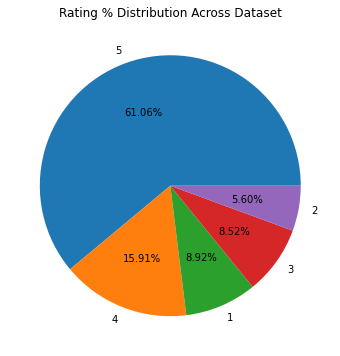

In [27]:
# Pie distribution of Rating (%)
plt.figure(figsize = (20,6))
plt.pie(Amazon["Rating"].value_counts(),labels = ["5", "4", "1", "3", "2"], autopct = "%1.2f%%")
plt.title("Rating % Distribution Across Dataset")
plt.show();

In [28]:
# Total count of unique ProductId
Amazon.ProductId.nunique()

23838

In [29]:
# Checking if unique urls are provied to unique ProductId
Amazon.ProductId.nunique(),Amazon.URL.nunique()

(23838, 23838)

In [30]:
# Distribution of Product Types: Value Counts Vs Unique ProductId
product_type_counts = Amazon["ProductType"].value_counts().reset_index()
product_type_counts.columns = ["ProductType", "Value_Count"]
unique_product_type_counts = Amazon.groupby("ProductType")["ProductId"].nunique().reset_index()
unique_product_type_counts.columns = ["ProductType", "Unique_ProductId_Count"]

merged_count = pd.merge(product_type_counts, unique_product_type_counts, on = "ProductType")
merged_count.sort_values(by = ["Value_Count"], ascending = False, inplace = True, ignore_index = True)
merged_count

,ProductType,Value_Count,Unique_ProductId_Count
0,Nail Polish,374551,5993
1,Shower Gel,204902,3928
2,Sunscreen,133427,2353
3,Shampoo,121436,2204
4,Face Wash & Cleansers,112020,1933
5,Hair Color & Heena,81871,1479
6,Face Serum,54001,875
7,Conditioner,50432,923
8,Body Lotion,46837,911
9,Cream & Moisturizer,34109,609


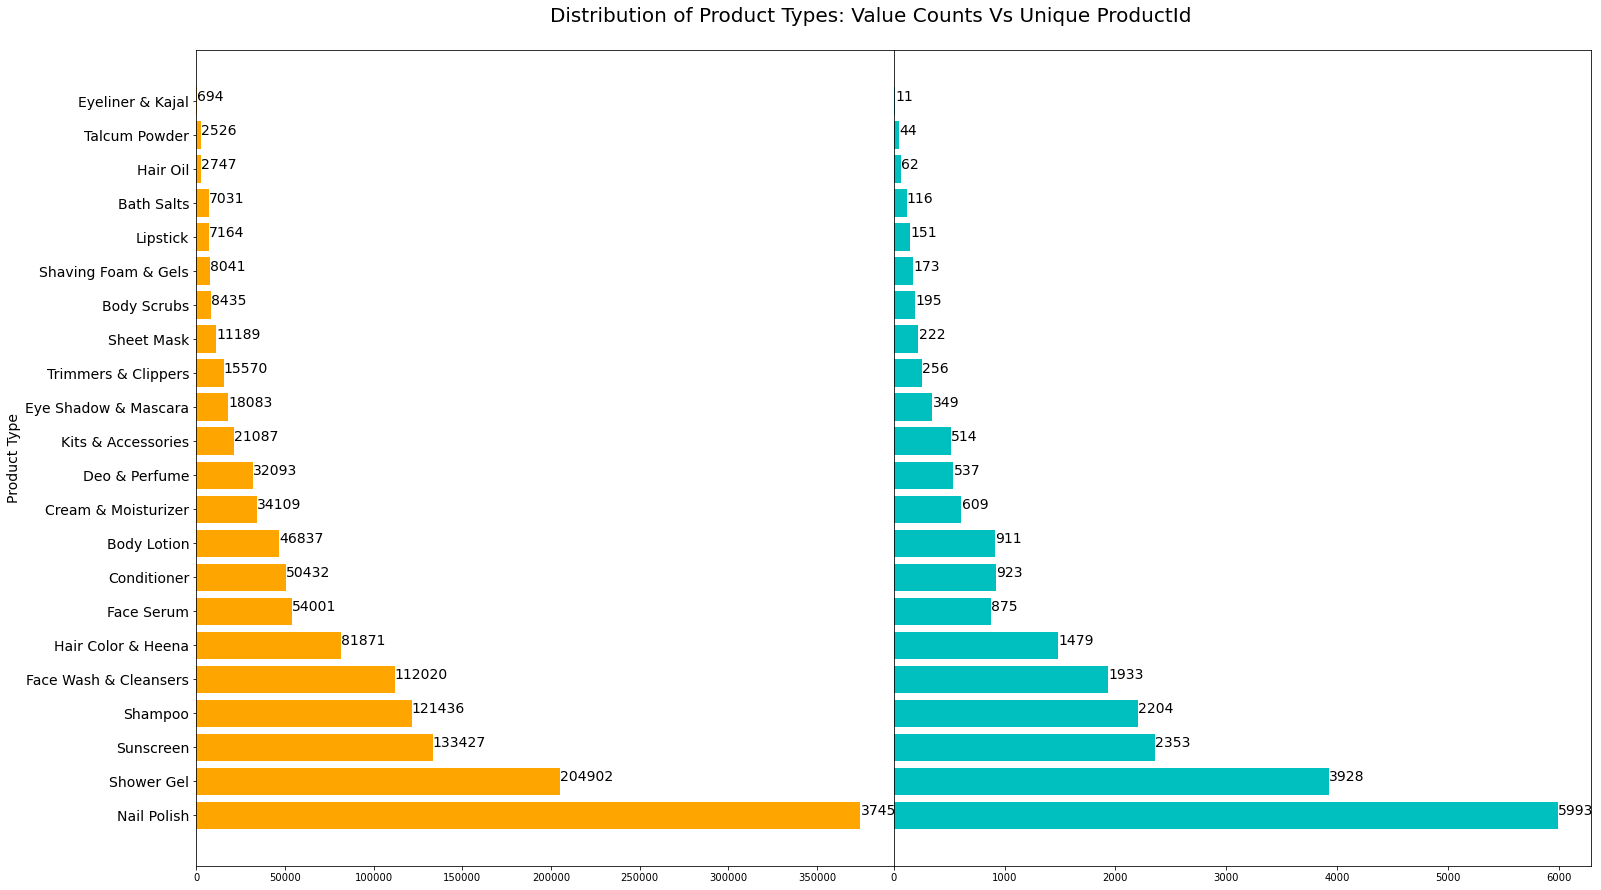

In [31]:
fig = plt.figure(figsize = (25,15))
plt.suptitle("Distribution of Product Types: Value Counts Vs Unique ProductId", size = 20, y = .92)

# Value counts of ProductType
plt.subplot(1,2,1)
plt.barh(merged_count.ProductType, merged_count.Value_Count, color = "orange")
plt.ylabel("Product Type", fontsize = 14)
plt.yticks(fontsize = 14)
for i, v in enumerate(merged_count.Value_Count):
    plt.text(v + 3, i, str(v), fontsize = 14)

# Unique counts of ProductId based on ProductType
plt.subplot(1,2,2)
plt.barh(merged_count.ProductType, merged_count.Unique_ProductId_Count, color = "c")
plt.yticks([], fontsize = 0)
for i, v in enumerate(merged_count.Unique_ProductId_Count):
    plt.text(v + 3, i, str(v), fontsize = 14)

plt.subplots_adjust(wspace = 0)
plt.show();

In [32]:
# Cross tab for Ratings distributed among ProductType
ct = pd.crosstab(Amazon["ProductType"], Amazon["Rating"], margins = True)
ct

Rating,1,2,3,4,5,All
ProductType,,,,,,
Bath Salts,214,173,448,1409,4787,7031
Body Lotion,4532,2873,4531,8120,26781,46837
Body Scrubs,846,486,767,1337,4999,8435
Conditioner,5168,3102,4986,8910,28266,50432
Cream & Moisturizer,2977,2032,3697,6973,18430,34109
Deo & Perfume,3035,1984,3415,6211,17448,32093
Eye Shadow & Mascara,1473,928,1584,2887,11211,18083
Eyeliner & Kajal,42,5,15,80,552,694
Face Serum,5239,3342,5393,9679,30348,54001


In [33]:
# Crosstab as per recommender system
pro = Amazon.pivot_table(index = "UserId", columns = "ProductType", values = "Rating").reset_index(drop = True)
pro.index = Amazon.UserId.unique() # set unique UserId from original dataset as index for new created pivot matrix
pro.fillna(0, inplace = True)      # Impute those NaNs with 0 values inplace-within the dataset
pro

ProductType,Bath Salts,Body Lotion,Body Scrubs,Conditioner,Cream & Moisturizer,Deo & Perfume,Eye Shadow & Mascara,Eyeliner & Kajal,Face Serum,Face Wash & Cleansers,...,Kits & Accessories,Lipstick,Nail Polish,Shampoo,Shaving Foam & Gels,Sheet Mask,Shower Gel,Sunscreen,Talcum Powder,Trimmers & Clippers
A3NHUQ33CFH3VM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1TIRNQ7O4REOH,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2Y36BR4YSY9F7,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A23H6FAOLEMAKC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3CHYZGF3OO6WD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AQ97CPL3HC77S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
A3MSBMHPF1T1O4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
A301UTEZ0VBPNB,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1UHVVGXETGO34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0


**Compressing the File**

In [34]:
# Load your CSV file into a Pandas DataFrame
df = pd.read_csv("Amazon_Beauty_Recommendation.csv")

# Convert the DataFrame to a bytes object
data_bytes = df.to_csv(index = False).encode("utf-8")

# Compress the data using the bz2 algorithm
compressed_data = bz2.compress(data_bytes)

# Write the compressed data to a file
with open('Amazon_Beauty_Recommendation.bz2', 'wb') as f:
    f.write(compressed_data)

In [35]:
# Read the compressed data and convert it back to a DataFrame
with open("Amazon_Beauty_Recommendation.bz2", "rb") as f:
    compressed_data = f.read()

# Decompress the data using the bz2 algorithm
decompressed_data = bz2.decompress(compressed_data)

# Convert the bytes object back to a DataFrame
beauty = pd.read_csv(io.StringIO(decompressed_data.decode("utf-8")))
beauty.head()

,UserId,ProductId,ProductType,Rating,Timestamp,URL
0,A3NHUQ33CFH3VM,B00LLPT4HI,Eyeliner & Kajal,5,1405814400,https://www.amazon.in/Maybelline-Colossal-Kaja...
1,A1TIRNQ7O4REOH,B00LLPT4HI,Eyeliner & Kajal,4,1405987200,https://www.amazon.in/Maybelline-Colossal-Kaja...
2,A2Y36BR4YSY9F7,B00LLPT4HI,Eyeliner & Kajal,5,1405728000,https://www.amazon.in/Maybelline-Colossal-Kaja...
3,A23H6FAOLEMAKC,B00LLPT4HI,Eyeliner & Kajal,5,1405814400,https://www.amazon.in/Maybelline-Colossal-Kaja...
4,A3CHYZGF3OO6WD,B00LLPT4HI,Eyeliner & Kajal,5,1405641600,https://www.amazon.in/Maybelline-Colossal-Kaja...


## Model Building
### Surprise 

In [36]:
# Loading and splitting the data
reader = Reader(rating_scale = (1, 5))
beauty_data = Dataset.load_from_df(beauty[["UserId", "ProductId", "Rating"]], reader)
trainset, testset = train_test_split(beauty_data, test_size = 0.25, random_state = 42)

In [37]:
# Create Model for recommending
model = SVD(n_factors = 50, reg_all = 0.02, lr_all = 0.005, n_epochs = 20)
model.fit(trainset)

# Predict ratings for testset
test_predictions = model.test(testset)

# Calculate MSE and RMSE
test_mse = accuracy.mse(test_predictions)
test_rmse = accuracy.rmse(test_predictions)

MSE: 1.5178
RMSE: 1.2320


### Final Model

In [38]:
model = SVD(n_factors = 50, reg_all = 0.02, lr_all = 0.005, n_epochs = 20)
model.fit(beauty_data.build_full_trainset())

In [39]:
# Function to recommend products based on user input
# If user is in the list, use recommender system elseif user is not in the list, recommend popular products 
def recommend_products(user_id, product_type):
    if user_id in beauty.UserId:
        product_list = beauty.loc[beauty["ProductType"] == product_type, "ProductId"].unique()
        predictions = [(product_id, model.predict(user_id, product_id).est) for product_id in product_list]
        sorted_predictions = sorted(predictions, key = lambda x: x[1], reverse = True)
        print("Top 5 products for user in the", product_type, "category:")
        for i in range(5):
            product_id = sorted_predictions[i][0]
            url = beauty.loc[beauty["ProductId"] == product_id, "URL"].iloc[0]
            print(i + 1, "- Product ID:", product_id, "\nURL:", url)
    else: 
        top_products = beauty.loc[beauty["ProductType"] == product_type].groupby("ProductId")["Rating"].mean().sort_values(ascending = False).index[:5]
        print("Top 5 products in the", product_type, "category:")
        for i, product_id in enumerate(top_products):
            url = beauty.loc[beauty["ProductId"] == product_id, "URL"].iloc[0]
            print(i + 1, "- Product ID:", product_id, "\nURL:", url)

In [40]:
recommend_products("AQ97CPL3HC77S", "Lipstick")

Top 5 products in the Lipstick category:
1 - Product ID: B00FPROWWU 
URL: https://www.amazon.in/SWISS-BEAUTY-Swiss-Beauty-Lipstick/dp/B07RWJ89ZD/ref=sr_1_48?pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=777489a8-ff36-4ced-b8a2-fe296c0f72d2&pf_rd_r=HAW9B7AZ6E1XMSTNXY9X&pf_rd_s=merchandised-search-13&qid=1680065924&refinements=p_85%3A10440599031%2Cp_28%3A-spons&rps=1&s=beauty&sr=1-48
2 - Product ID: B00FJFUW40 
URL: https://www.amazon.in/SUGAR-Cosmetics-Smudge-Liquid-Lipstick/dp/B0822KZ799/ref=sr_1_23?pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=777489a8-ff36-4ced-b8a2-fe296c0f72d2&pf_rd_r=HAW9B7AZ6E1XMSTNXY9X&pf_rd_s=merchandised-search-13&qid=1680065928&refinements=p_85%3A10440599031%2Cp_28%3A-spons&rps=1&s=beauty&sr=1-23
3 - Product ID: B00F48C08S 
URL: https://www.amazon.in/SWISS-BEAUTY-Swiss-Beauty-Lipstick/dp/B07RWJ7FM5/ref=sr_1_36?pf_rd_i=1355016031&pf_rd_m=A1VBAL9TL5WCBF&pf_rd_p=777489a8-ff36-4ced-b8a2-fe296c0f72d2&pf_rd_r=HAW9B7AZ6E1XMSTNXY9X&pf_rd_s=merchandised-search